### Install Necessary Libraries ich


pip install transformers
pip install torch
pip install sklearn
pip install pandas
pip install rich


### Import Libraries:

In [1]:
!pip install transformers[torch]
!pip install accelerate -U
!pip install datasets
!pip install datasets langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 4.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
import pandas as pd
import numpy as np
import langid
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
from rich.progress import track

### Load and Preprocess Dataset:

In [5]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/sds.csv')

In [6]:
pd.set_option('max_colwidth', None)

In [7]:
df.head()

,Date,text,Sentiment
0,2019-05-27,È appena uscito un nuovo video! LES CRYPTOMONNAIES QUI PULVÉRISENT BITCOIN EN 2019 https://t.co/yCsQMvRnyS,Positive
1,2019-05-27,Cardano: Digitize Currencies; EOS https://t.co/1kTKqKEBlS 6500% ROI; AT&amp;T Bitcoin Bill Pay https://t.co/eQCwOXKHK0 | Cardano (ADA) 🌏📢😎🤑💵 | #FolloForFolloBack #follo4folloback #followforfollow #bitcointe #cryptocurrency,Positive
2,2019-05-27,Another Test tweet that wasn't caught in the stream ! bitcoin,Positive
3,2019-05-27,Current Crypto Prices! \n\nBTC: $8721.99 USD\nETH: $266.62 USD\nLTC: $114.03 USD\nBCH: $432.02 USD\nXLM: $0.133 USD\nDOGE: $ 0.00314 USD\nNEO: $12.04 USD\nXRP: $0.4092 USD\nCANN: $0.001482 USD\nEMC2: $0.1198 USD\nXMR: $94.65 USD\nBTG: $24.31 USD,Positive
4,2019-05-27,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NOT A Currency.\n\nhttps://t.co/FJru1ooxSM\n\nhttps://t.co/fYBX4H6r6r\n\nhttps://t.co/xZSjmZ0h3K\n\nhttps://t.co/v7GRFIQG7w\n\nhttps://t.co/Oq5hQt5hNn,Positive


In [8]:
sentiment_count = df['Sentiment'].value_counts()
print(sentiment_count)

Sentiment
Negative    9729297
Positive    8723207
Neutral         400
Name: count, dtype: int64


In [9]:
df.shape

(19344048, 3)

In [10]:
# Reduce the dataset size for manageability
negativedf = df[df['Sentiment'] == 'Negative'].sample(n=10000, random_state=42)
positivedf = df[df['Sentiment'] == 'Positive'].sample(n=10000, random_state=42)
neutraldf = df[df['Sentiment'] == 'Neutral']

In [11]:
df.shape

(19344048, 3)

(20400, 3)


<Axes: title={'center': 'Sentiment Distribution Count'}, xlabel='Sentiment'>

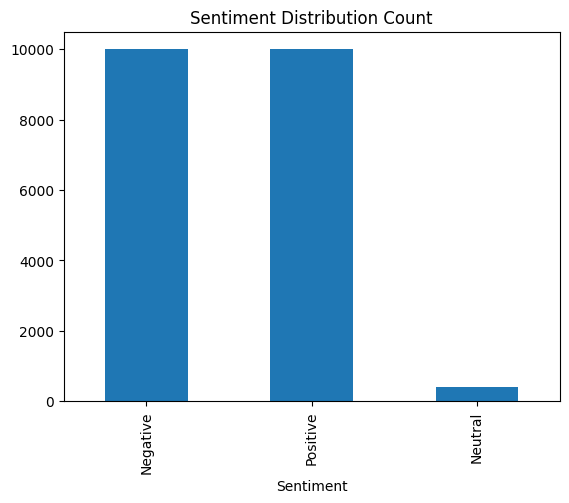

In [12]:
# Concatenate the reduced datasets
df = pd.concat([negativedf, neutraldf, positivedf])
print(df.shape)
df['Sentiment'].value_counts().plot(kind='bar',title='Sentiment Distribution Count')

In [13]:
# Detect language for each row
df['lang'] = None
for index, row in track(df.iterrows(), total=len(df)):
    text = row['text']
    if isinstance(text, str):
        language, confidence = langid.classify(text)
        df.at[index, 'lang'] = language
    else:
        df.at[index, 'lang'] = 'unknown'

Output()

In [14]:
# Filter only English tweets
df = df[df['lang'] == 'en']
print(df.shape)

# Clean dataset by removing links, hashtags, etc.
df['text'] = df['text'].str.replace(r'http\S+', '', regex=True).str.replace(r'#\w+', '', regex=True).str.replace(r'@\w+', '', regex=True).str.replace(r'\d+', '', regex=True)

# Map sentiments to integers
sentiment_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df['label'] = df['Sentiment'].map(sentiment_mapping)

(14172, 4)


<ipython-input-14-b4df2295d2ff>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].str.replace(r'http\S+', '', regex=True).str.replace(r'#\w+', '', regex=True).str.replace(r'@\w+', '', regex=True).str.replace(r'\d+', '', regex=True)
<ipython-input-14-b4df2295d2ff>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['Sentiment'].map(sentiment_mapping)


### Prepare Data for BERT:

In [15]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

dataset = Dataset.from_pandas(df[['text', 'label']])
tokenized_datasets = dataset.map(tokenize_function, batched=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/14172 [00:00<?, ? examples/s]

### Split the Dataset

In [16]:
train_test_split_ratio = 0.8
split = tokenized_datasets.train_test_split(test_size=1 - train_test_split_ratio)
train_dataset = split['train']
test_dataset = split['test']

### Fine-Tune the BERT Model:

In [17]:
# Load the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Define metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    acc = accuracy_score(p.label_ids, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,  # Reduced batch size
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    gradient_accumulation_steps=2,  # Use gradient accumulation
)

# Define the data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.738500,0.674444,0.577778,0.548158,0.602744,0.577778
2,0.684500,0.674786,0.556614,0.552567,0.560036,0.556614
3,0.600000,0.720590,0.567549,0.567478,0.567837,0.567549


TrainOutput(global_step=2127, training_loss=0.6654291121568487, metrics={'train_runtime': 3451.978, 'train_samples_per_second': 9.853, 'train_steps_per_second': 0.616, 'total_flos': 8948750450347008.0, 'train_loss': 0.6654291121568487, 'epoch': 3.0})

### Evaluate the Model:

In [20]:
# Evaluate the model
eval_result = trainer.evaluate()
print(eval_result)


{'eval_loss': 0.7205900549888611, 'eval_accuracy': 0.5675485008818342, 'eval_f1': 0.5674784964022636, 'eval_precision': 0.5678365505012666, 'eval_recall': 0.5675485008818342, 'eval_runtime': 81.7504, 'eval_samples_per_second': 34.679, 'eval_steps_per_second': 4.342, 'epoch': 3.0}


### Save the Model

In [25]:
# Save the fine-tuned model
model.save_pretrained('./fine-tuned-bert')
tokenizer.save_pretrained('./fine-tuned-bert')


('./fine-tuned-bert/tokenizer_config.json',
 './fine-tuned-bert/special_tokens_map.json',
 './fine-tuned-bert/vocab.txt',
 './fine-tuned-bert/added_tokens.json')

In [22]:
import shutil

folder_path = '/content/results'
zip_path = '/content/results.zip'

shutil.make_archive(zip_path, 'zip', folder_path)


'/content/results.zip.zip'